In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=6a894b3421cd99258754e24971e33b154dcc6fe6aee8ee5388a11a2e95d52c23
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [5]:
spark = SparkSession.builder.appName("Stroke Prediction").getOrCreate()
data = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/healthcare-dataset-stroke-data.csv", header=True, inferSchema=True)
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [6]:
df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/healthcare-dataset-stroke-data.csv', inferSchema=True, header=True)

In [7]:
print(f"Instâncias: {df.count()}")
print(f"Características: {len(df.columns)}")


Instâncias: 5110
Características: 12


In [9]:
from pyspark.sql.types import StringType

string_vars = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
print(f"Variáveis do tipo string: {len(string_vars)}")


Variáveis do tipo string: 6


In [10]:
from pyspark.sql.functions import avg

df.select(avg("age")).show()


+------------------+
|          avg(age)|
+------------------+
|43.226614481409015|
+------------------+



In [11]:
df.groupBy("gender", "stroke").count().show()


+------+------+-----+
|gender|stroke|count|
+------+------+-----+
|  Male|     1|  108|
| Other|     0|    1|
|Female|     0| 2853|
|  Male|     0| 2007|
|Female|     1|  141|
+------+------+-----+



In [12]:
# Contagem de instâncias de AVC
df.groupBy("stroke").count().show()

# Tipos de 'Residence_type'
df.select("Residence_type").distinct().show()

# Verificação de tipos de dados
df.printSchema()

# Contagem de valores não numéricos para 'bmi'
df.filter(df['bmi'].rlike('[^0-9.]')).count()


+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+

+--------------+
|Residence_type|
+--------------+
|         Urban|
|         Rural|
+--------------+

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



201

In [17]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Lista das colunas que precisam ser indexadas
string_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'bmi', 'smoking_status']

# Criando os indexadores
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in string_columns]

# Criando um pipeline e transformando o dataframe
pipeline = Pipeline(stages=indexers)
df_r = pipeline.fit(df).transform(df)

# Removendo as colunas originais de string
df_r = df_r.select([column for column in df_r.columns if column not in string_columns])

# Agora a lista de colunas de características deve ser a lista de colunas de índices
feature_columns = [column for column in df_r.columns if column != "stroke"]

# Continuando com o código, podemos criar o VectorAssembler:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transformando os dados
df = assembler.transform(df_r)

# Dividindo os dados em conjuntos de treino e teste
train_data, test_data = df.randomSplit([0.8, 0.2], seed=123)

# Criando o modelo de regressão logística
lr = LogisticRegression(featuresCol="features", labelCol="stroke")

# Treinando o modelo
lr_model = lr.fit(train_data)

# Agora você pode usar `lr_model` para fazer previsões
predictions = lr_model.transform(test_data)


In [18]:
df.approxQuantile("avg_glucose_level", [0.5], 0)

[91.88]

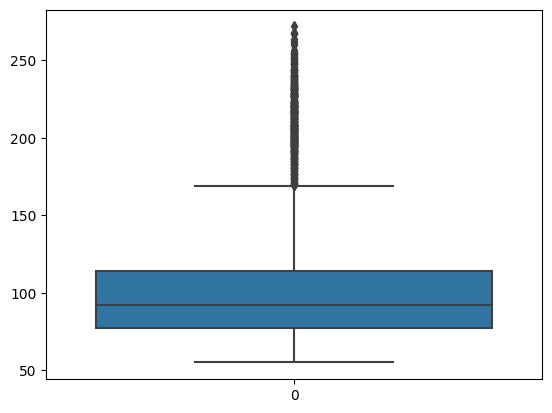

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convertendo o DataFrame do PySpark para o pandas
pandas_df = df.toPandas()

# Criando o boxplot para 'avg_glucose_level'
sns.boxplot(data=pandas_df['avg_glucose_level'])
plt.show()


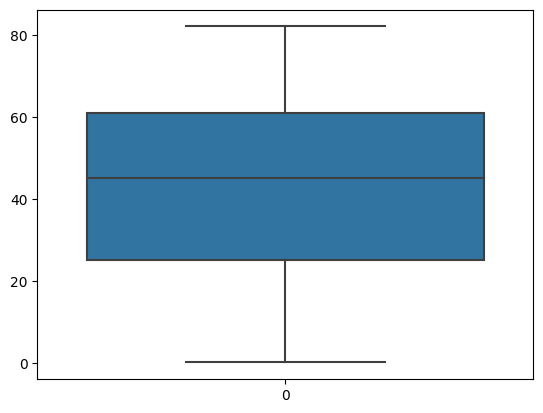

In [21]:
# Criando o boxplot para 'age'
sns.boxplot(data=pandas_df['age'])
plt.show()


In [24]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [25]:
import pandas as pd

In [28]:
distinct_work_type_index_count = df.select("work_type_index").distinct().count()
print(distinct_work_type_index_count)


5


In [35]:
# Carregando o dataset original
original_df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/healthcare-dataset-stroke-data.csv", header=True, inferSchema=True)


In [36]:
# Contando as diferentes instâncias de 'work_type'
work_type_counts = original_df.groupBy("work_type").count().sort('count', ascending=False)

# Visualizando os resultados
work_type_counts.show()


+-------------+-----+
|    work_type|count|
+-------------+-----+
|      Private| 2925|
|Self-employed|  819|
|     children|  687|
|     Govt_job|  657|
| Never_worked|   22|
+-------------+-----+



In [38]:
df.printSchema()


root
 |-- id: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- gender_index: double (nullable = false)
 |-- ever_married_index: double (nullable = false)
 |-- work_type_index: double (nullable = false)
 |-- Residence_type_index: double (nullable = false)
 |-- bmi_index: double (nullable = false)
 |-- smoking_status_index: double (nullable = false)
 |-- features: vector (nullable = true)



In [39]:
distinct_classes_count = df.select("work_type_index").distinct().count()
print(distinct_classes_count)


5


In [40]:
distinct_smoking_status_classes = df.select("smoking_status_index").distinct().count()
print(distinct_smoking_status_classes)


4


In [41]:
from pyspark.sql.functions import col, countDistinct


In [43]:
distinct_smoking_status_count = df.select("smoking_status_index").distinct().count()


In [47]:
if "bmi" in df.columns:
    bmi_data_type = df.schema["bmi"].dataType
    print("Tipo de dados da variável 'bmi':", bmi_data_type)
else:
    print("A coluna 'bmi' não está presente no DataFrame.")


A coluna 'bmi' não está presente no DataFrame.


In [50]:
print(df.schema)


StructType([StructField('id', IntegerType(), True), StructField('age', DoubleType(), True), StructField('hypertension', IntegerType(), True), StructField('heart_disease', IntegerType(), True), StructField('avg_glucose_level', DoubleType(), True), StructField('stroke', IntegerType(), True), StructField('gender_index', DoubleType(), False), StructField('ever_married_index', DoubleType(), False), StructField('work_type_index', DoubleType(), False), StructField('Residence_type_index', DoubleType(), False), StructField('bmi_index', DoubleType(), False), StructField('smoking_status_index', DoubleType(), False), StructField('features', VectorUDT(), True)])


In [51]:
is_bmi_numeric = df.schema["bmi_index"].dataType.typeName() in ['double', 'float', 'integer', 'long', 'short']
print("A variável 'bmi' possui apenas valores numéricos?", is_bmi_numeric)


A variável 'bmi' possui apenas valores numéricos? True


In [54]:
from pyspark.sql.functions import count, when

# Verificar o número de classes diferentes de "smoking_status" após o agrupamento
distinct_smoking_status_count = df.groupBy("smoking_status_index").agg(count("*").alias("count")).count()
print("Número de classes diferentes de 'smoking_status' após o agrupamento:", distinct_smoking_status_count)

# Verificar a quantidade de indivíduos de cada classe de "smoking_status" entre os que sofreram AVC
stroke_smoking_status_counts = df.filter(df.stroke == 1).groupBy("smoking_status_index").agg(count("*").alias("count"))
stroke_smoking_status_counts.show()

# Verificar se existe uma maior quantidade de indivíduos que sofreram AVC
max_count = stroke_smoking_status_counts.agg({"count": "max"}).collect()[0][0]
is_max_count = stroke_smoking_status_counts.filter(stroke_smoking_status_counts["count"] == max_count).count() > 1
print("Existe uma maior quantidade de indivíduos que sofreram AVC?", is_max_count)


Número de classes diferentes de 'smoking_status' após o agrupamento: 4
+--------------------+-----+
|smoking_status_index|count|
+--------------------+-----+
|                 0.0|   90|
|                 1.0|   47|
|                 3.0|   42|
|                 2.0|   70|
+--------------------+-----+

Existe uma maior quantidade de indivíduos que sofreram AVC? False


In [55]:
from pyspark.sql.functions import col, sum

# Verificar a quantidade de missing values em cada coluna
missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()


+---+---+------------+-------------+-----------------+------+------------+------------------+---------------+--------------------+---------+--------------------+--------+
| id|age|hypertension|heart_disease|avg_glucose_level|stroke|gender_index|ever_married_index|work_type_index|Residence_type_index|bmi_index|smoking_status_index|features|
+---+---+------------+-------------+-----------------+------+------------+------------------+---------------+--------------------+---------+--------------------+--------+
|  0|  0|           0|            0|                0|     0|           0|                 0|              0|                   0|        0|                   0|       0|
+---+---+------------+-------------+-----------------+------+------------+------------------+---------------+--------------------+---------+--------------------+--------+



In [56]:
# Obter o total de registros no DataFrame
total_records = df.count()

# Calcular a porcentagem de missing values em cada coluna
missing_values_percentage = missing_values.select([(col(c) / total_records).alias(c) for c in missing_values.columns])
missing_values_percentage.show()


+---+---+------------+-------------+-----------------+------+------------+------------------+---------------+--------------------+---------+--------------------+--------+
| id|age|hypertension|heart_disease|avg_glucose_level|stroke|gender_index|ever_married_index|work_type_index|Residence_type_index|bmi_index|smoking_status_index|features|
+---+---+------------+-------------+-----------------+------+------------+------------------+---------------+--------------------+---------+--------------------+--------+
|0.0|0.0|         0.0|          0.0|              0.0|   0.0|         0.0|               0.0|            0.0|                 0.0|      0.0|                 0.0|     0.0|
+---+---+------------+-------------+-----------------+------+------------+------------------+---------------+--------------------+---------+--------------------+--------+



In [57]:
from pyspark.sql.functions import col

# Filtrar os registros em que o smoking_status é "never smoked" e stroke é igual a 1
never_smoked_with_stroke = df.filter((col("smoking_status") == "never smoked") & (col("stroke") == 1))

# Contar o número de registros resultantes
count_never_smoked_with_stroke = never_smoked_with_stroke.count()

print("Número de indivíduos que nunca fumaram e sofreram AVC:", count_never_smoked_with_stroke)


Número de indivíduos que nunca fumaram e sofreram AVC: 90


In [63]:
from pyspark.sql.functions import col

# Filtrar apenas os registros com AVC (stroke = 1) e nunca fumaram (never smoked)
avc_never_smoked = df.filter((col("stroke") == 1) & (col("smoking_status") == "never smoked"))

# Contar o número de indivíduos que nunca fumaram e sofreram AVC
count_never_smoked = avc_never_smoked.count()

# Filtrar apenas os registros com AVC (stroke = 1)
avc_all = df.filter(col("stroke") == 1)

# Contar o número total de indivíduos que sofreram AVC
count_all = avc_all.count()

# Verificar a proporção de indivíduos que nunca fumaram entre os que sofreram AVC
prop_never_smoked = count_never_smoked / count_all

# Imprimir o resultado
print("Número de indivíduos que nunca fumaram e sofreram AVC:", count_never_smoked)
print("Proporção de indivíduos que nunca fumaram entre os que sofreram AVC:", prop_never_smoked)


Número de indivíduos que nunca fumaram e sofreram AVC: 90
Proporção de indivíduos que nunca fumaram entre os que sofreram AVC: 0.3614457831325301


In [64]:
from pyspark.sql.functions import count

# Contar o número de indivíduos que sofreram e não sofreram AVC
avc_counts = df.groupBy("stroke").agg(count("*").alias("count"))

# Exibir o resultado
avc_counts.show()


+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+



In [65]:
from pyspark.sql.functions import col

# Filtrar o DataFrame para obter os indivíduos que sofreram AVC
avc_df = df.filter(col("stroke") == 1)

# Filtrar o DataFrame para obter os indivíduos que não sofreram AVC
no_avc_df = df.filter(col("stroke") == 0)

# Calcular a proporção de hipertensão entre os que sofreram AVC
avc_hypertension_ratio = avc_df.filter(col("hypertension") == 1).count() / avc_df.count()

# Calcular a proporção de hipertensão entre os que não sofreram AVC
no_avc_hypertension_ratio = no_avc_df.filter(col("hypertension") == 1).count() / no_avc_df.count()

# Exibir os resultados
print("Proporção de hipertensão entre os que sofreram AVC:", avc_hypertension_ratio)
print("Proporção de hipertensão entre os que não sofreram AVC:", no_avc_hypertension_ratio)


Proporção de hipertensão entre os que sofreram AVC: 0.26506024096385544
Proporção de hipertensão entre os que não sofreram AVC: 0.08887060275663444


In [69]:
# aplicando a transformação dos dados categóricos
from pyspark.ml.feature import VectorAssembler,OneHotEncoder, StringIndexer

In [70]:
#define a transformação para a variável "gender"
stringIndexer_gender=StringIndexer(inputCol="gender", outputCol="gender_encoded")  #label encoding
encoder_gender = OneHotEncoder(dropLast=False, inputCol="gender_encoded", outputCol="genderVec") #one-hot encoding

In [71]:
#define a transformação para a variável "gender"
stringIndexer_gender=StringIndexer(inputCol="gender", outputCol="gender_encoded")  #label encoding
encoder_gender = OneHotEncoder(dropLast=False, inputCol="gender_encoded", outputCol="genderVec") #one-hot encoding

In [72]:
#define a transformação para a variável "work_type"
stringIndexer_work=StringIndexer(inputCol="work_type", outputCol="work_type_encoded")  #label encoding
encoder_work = OneHotEncoder(dropLast=False, inputCol="work_type_encoded", outputCol="workVec") #one-hot encoding

In [73]:
#define a transformação para a variável "Residence_type"
stringIndexer_residence=StringIndexer(inputCol="Residence_type", outputCol="Residence_type_encoded")  #label encoding
encoder_residence = OneHotEncoder(dropLast=False, inputCol="Residence_type_encoded", outputCol="residenceVec") #one-hot encoding

In [74]:
#define a transformação para a variável "smoking_status"
stringIndexer_smoking=StringIndexer(inputCol="smoking_status", outputCol="smoking_status_encoded")  #define o objeto
encoder_smoking = OneHotEncoder(dropLast=False, inputCol="smoking_status_encoded", outputCol="smokingVec")#one-hot encoding

In [75]:
#define a transformação para a variável "smoking_status"
stringIndexer_smoking=StringIndexer(inputCol="smoking_status", outputCol="smoking_status_encoded")  #define o objeto
encoder_smoking = OneHotEncoder(dropLast=False, inputCol="smoking_status_encoded", outputCol="smokingVec")#one-hot encoding

In [80]:
# Define a sequência de transformações para o pipeline
sequencia_transformacoes = [
    stringIndexer_gender, stringIndexer_married, stringIndexer_work,
    stringIndexer_residence, stringIndexer_smoking, encoder_gender,
    encoder_married, encoder_work, encoder_residence, encoder_smoking,
    vector_assembler
]


In [84]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer

# Definir transformações para cada variável categórica
stringIndexer_gender = StringIndexer(inputCol="gender", outputCol="gender_encoded")
encoder_gender = OneHotEncoder(dropLast=False, inputCol="gender_encoded", outputCol="genderVec")

stringIndexer_married = StringIndexer(inputCol="ever_married", outputCol="ever_married_encoded")
encoder_married = OneHotEncoder(dropLast=False, inputCol="ever_married_encoded", outputCol="marriedVec")

stringIndexer_work = StringIndexer(inputCol="work_type", outputCol="work_type_encoded")
encoder_work = OneHotEncoder(dropLast=False, inputCol="work_type_encoded", outputCol="workVec")

stringIndexer_residence = StringIndexer(inputCol="Residence_type", outputCol="Residence_type_encoded")
encoder_residence = OneHotEncoder(dropLast=False, inputCol="Residence_type_encoded", outputCol="residenceVec")

stringIndexer_smoking = StringIndexer(inputCol="smoking_status", outputCol="smoking_status_encoded")
encoder_smoking = OneHotEncoder(dropLast=False, inputCol="smoking_status_encoded", outputCol="smokingVec")

# Definir colunas de entrada para o vetor
colunas_entrada = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'genderVec', 'marriedVec', 'workVec', 'residenceVec', 'smokingVec']
vetor_entrada = VectorAssembler(inputCols=colunas_entrada, outputCol='features')

# Definir sequência de transformações para o pipeline
sequencia_transformacoes = [
    stringIndexer_gender, stringIndexer_married, stringIndexer_work,
    stringIndexer_residence, stringIndexer_smoking, encoder_gender,
    encoder_married, encoder_work, encoder_residence, encoder_smoking,
    vetor_entrada
]

# Aplicar o pipeline
pipeline = Pipeline(stages=sequencia_transformacoes)
pipelineModel = pipeline.fit(df)
model = pipelineModel.transform(df)


Py4JJavaError: ignored

In [85]:
df.columns

['id',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'stroke',
 'gender_index',
 'ever_married_index',
 'work_type_index',
 'Residence_type_index',
 'bmi_index',
 'smoking_status_index',
 'features']

In [87]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Definir as transformações para as variáveis categóricas
stringIndexer_gender = StringIndexer(inputCol="gender_index", outputCol="gender_encoded")
encoder_gender = OneHotEncoder(dropLast=False, inputCol="gender_encoded", outputCol="genderVec")

stringIndexer_married = StringIndexer(inputCol="ever_married_index", outputCol="ever_married_encoded")
encoder_married = OneHotEncoder(dropLast=False, inputCol="ever_married_encoded", outputCol="marriedVec")

stringIndexer_work = StringIndexer(inputCol="work_type_index", outputCol="work_type_encoded")
encoder_work = OneHotEncoder(dropLast=False, inputCol="work_type_encoded", outputCol="workVec")

stringIndexer_residence = StringIndexer(inputCol="Residence_type_index", outputCol="Residence_type_encoded")
encoder_residence = OneHotEncoder(dropLast=False, inputCol="Residence_type_encoded", outputCol="residenceVec")

stringIndexer_smoking = StringIndexer(inputCol="smoking_status_index", outputCol="smoking_status_encoded")
encoder_smoking = OneHotEncoder(dropLast=False, inputCol="smoking_status_encoded", outputCol="smokingVec")

# Definir a construção do vetor de entrada
colunas_entrada = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'genderVec', 'marriedVec', 'workVec', 'residenceVec', 'smokingVec']
vetor_entrada = VectorAssembler(inputCols=colunas_entrada, outputCol='inputFeatures')

# Definir a sequência de transformações para o pipeline
sequencia_transformacoes = [
    stringIndexer_gender, stringIndexer_married, stringIndexer_work,
    stringIndexer_residence, stringIndexer_smoking, encoder_gender,
    encoder_married, encoder_work, encoder_residence, encoder_smoking,
    vetor_entrada
]

# Aplicar o pipeline
pipeline = Pipeline(stages=sequencia_transformacoes)
pipelineModel = pipeline.fit(df)
model = pipelineModel.transform(df)


In [90]:
#mostrando parte dos dados para entrada
model.select('age','gender','genderVec','ever_married','marriedVec','features').show()

AnalysisException: ignored

In [91]:
#dividindo o dataset entre teste e treinamento
train_data, test_data = model.randomSplit([.8,.2],seed=1)

In [92]:
#mostrando os dados de treinamento
train_data.columns

['id',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'stroke',
 'gender_index',
 'ever_married_index',
 'work_type_index',
 'Residence_type_index',
 'bmi_index',
 'smoking_status_index',
 'features',
 'gender_encoded',
 'ever_married_encoded',
 'work_type_encoded',
 'Residence_type_encoded',
 'smoking_status_encoded',
 'genderVec',
 'marriedVec',
 'workVec',
 'residenceVec',
 'smokingVec',
 'inputFeatures']

In [96]:
#define o modelo de regrssão logística
from pyspark.ml.classification import LogisticRegression

#instancia o objeto para a regressão logística
lr = LogisticRegression(labelCol="stroke",featuresCol="features", maxIter=100, regParam=0.3, )

# treina o modelo
linearModel = lr.fit(train_data)

In [94]:
#realiza a previsão utilizando o modelo de regressão logística
previsao_regressao = linearModel.transform(test_data)

In [95]:
#avaliando a classificação realizada pela regressão logística
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
acuracia_regressao = acc_evaluator.evaluate(previsao_regressao)
print('Regressão Logística: {0:2.2f}%'.format(acuracia_regressao*100))

Regressão Logística: 95.06%
